In [1]:
import os
from pathlib import Path

# 方法 1：相對於 notebook 位置
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # 從 model/aapl 往上兩層
os.chdir(project_root)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np
import ta

In [3]:
df = pd.read_csv("data/2330_TW.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14)
df['k'] = stoch.stoch()
df['d'] = stoch.stoch_signal()
df

,Close,High,Low,Open,Volume,rsi,k,d
Date,,,,,,,,
2014-01-03,73.997704,74.358668,73.636739,74.358668,38599000,NaN,NaN,NaN
2014-01-06,73.997704,74.358668,73.636739,73.636739,23706000,NaN,NaN,NaN
2014-01-07,73.636726,74.358655,73.636726,73.997691,15836000,NaN,NaN,NaN
2014-01-08,75.080612,75.441577,73.997719,74.358683,30218000,NaN,NaN,NaN
2014-01-09,72.914787,74.358644,72.553823,73.997680,63998000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-25,564.011108,567.894145,563.040349,564.981868,9548143,58.299930,71.936110,67.926818
2023-12-26,568.864929,568.864929,564.981892,565.952651,16094308,62.416420,91.982151,79.954442
2023-12-27,574.689453,574.689453,568.864898,569.835657,33401336,66.668544,100.000000,87.972754


In [4]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 3])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume','rsi','k','d']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 5 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)



(2439, 4)


In [5]:
class GRU(nn.Module):
    def __init__(self, n_features, hidden_dim, predict_day):
        super(GRU, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.predict_day = predict_day
        
        # GRU layer
        self.gru = nn.GRU(input_size=self.n_features, hidden_size=self.hidden_dim, 
                          num_layers=2, bidirectional=False, batch_first=True, dropout=0.2)
        
        # Fully connected output layer
        self.linear = nn.Linear(self.hidden_dim, self.predict_day)
        
    def forward(self, x): 
        # GRU forward pass
        x, _ = self.gru(x)
        
        # Pass the last time step's output to the linear layer
        x = self.linear(x[:, -1, :])  # (batch_size, predict_day)
        
        return x


In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
model = GRU(n_features=4, hidden_dim=128, predict_day=5)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [7]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_val_loss = float('inf')
best_model_path = "output/model/2330tw/gru_5.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save(model, best_model_path)



Epoch [1/100], Train Loss: 0.0048, Val Loss: 0.0020
Epoch [2/100], Train Loss: 0.0166, Val Loss: 0.0075
Epoch [3/100], Train Loss: 0.0144, Val Loss: 0.0026
Epoch [4/100], Train Loss: 0.0052, Val Loss: 0.0006
Epoch [5/100], Train Loss: 0.0007, Val Loss: 0.0006
Epoch [6/100], Train Loss: 0.0008, Val Loss: 0.0016
Epoch [7/100], Train Loss: 0.0008, Val Loss: 0.0008
Epoch [8/100], Train Loss: 0.0008, Val Loss: 0.0014
Epoch [9/100], Train Loss: 0.0006, Val Loss: 0.0012
Epoch [10/100], Train Loss: 0.0006, Val Loss: 0.0019
Epoch [11/100], Train Loss: 0.0006, Val Loss: 0.0013
Epoch [12/100], Train Loss: 0.0006, Val Loss: 0.0021
Epoch [13/100], Train Loss: 0.0007, Val Loss: 0.0010
Epoch [14/100], Train Loss: 0.0006, Val Loss: 0.0024
Epoch [15/100], Train Loss: 0.0008, Val Loss: 0.0011
Epoch [16/100], Train Loss: 0.0006, Val Loss: 0.0019
Epoch [17/100], Train Loss: 0.0006, Val Loss: 0.0019
Epoch [18/100], Train Loss: 0.0007, Val Loss: 0.0012
Epoch [19/100], Train Loss: 0.0008, Val Loss: 0.0015
Ep

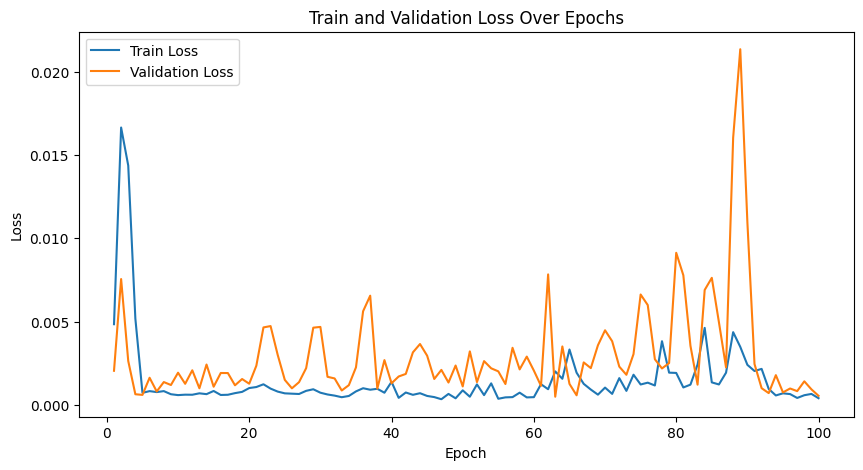

In [8]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

In [9]:
import matplotlib.pyplot as plt
print(len(Y_test))
close_price_true = []
temp_real = []
real = Y_test.detach().cpu().numpy()
for i in range(len(Y_test)):
   temp_real.append(real[i][0])
temp_real = np.array(temp_real)
temp_real = temp_real.reshape(-1, 1)
temp_real = np.repeat(temp_real, 4, axis=1)
# print(close_price_true)
temp_real = scaler.inverse_transform(temp_real)
# print(temp_real)
for i in range(len(temp_real)):
   close_price_true.append(temp_real[i][3])
print(close_price_true)


200
[np.float32(495.33398), np.float32(495.33392), np.float32(499.13693), np.float32(489.62958), np.float32(487.72806), np.float32(485.82663), np.float32(489.62958), np.float32(482.71985), np.float32(493.2345), np.float32(494.1904), np.float32(492.27866), np.float32(500.88162), np.float32(504.70505), np.float32(512.35205), np.float32(509.48444), np.float32(501.83743), np.float32(509.48453), np.float32(512.3522), np.float32(514.2639), np.float32(506.61685), np.float32(511.3962), np.float32(509.48444), np.float32(498.96976), np.float32(499.92575), np.float32(492.2787), np.float32(493.23444), np.float32(496.1022), np.float32(495.14624), np.float32(494.19043), np.float32(489.41098), np.float32(497.058), np.float32(482.7198), np.float32(481.7639), np.float32(476.0287), np.float32(469.3375), np.float32(476.50665), np.float32(477.94043), np.float32(474.11688), np.float32(475.07272), np.float32(477.9403), np.float32(486.5433), np.float32(484.63165), np.float32(485.58752), np.float32(483.6757),

[np.float32(491.69855), np.float32(493.87128), np.float32(492.71155), np.float32(494.44116), np.float32(490.08792), np.float32(490.15152), np.float32(489.33835), np.float32(490.188), np.float32(488.05386), np.float32(494.75986), np.float32(494.60272), np.float32(494.86078), np.float32(502.86853), np.float32(506.62115), np.float32(509.00128), np.float32(507.69284), np.float32(507.6549), np.float32(509.40875), np.float32(511.58923), np.float32(512.43774), np.float32(510.0176), np.float32(511.08826), np.float32(509.93933), np.float32(507.2125), np.float32(506.2198), np.float32(502.19943), np.float32(503.22147), np.float32(504.2201), np.float32(501.13947), np.float32(499.77203), np.float32(498.70468), np.float32(499.2782), np.float32(494.3886), np.float32(490.65152), np.float32(487.81982), np.float32(485.53403), np.float32(488.82132), np.float32(488.18323), np.float32(485.73203), np.float32(486.85718), np.float32(487.7527), np.float32(490.2331), np.float32(491.60922), np.float32(488.90262)

C:\Users\N98141062\AppData\Local\Temp\ipykernel_22904\2939709727.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/2330tw/gru_5.pth')


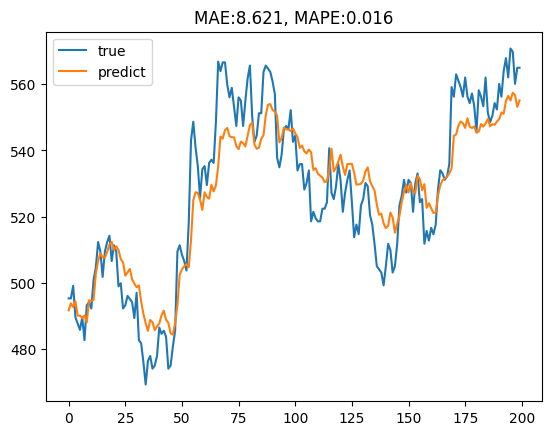

In [10]:
from sklearn.metrics import r2_score
close_price_pred = []
model = torch.load('output/model/2330tw/gru_5.pth')
model.to(device)
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()[0]
    pred = pred.reshape(-1, 1)
    # print(pred)
    pred = np.repeat(pred, 4, axis=1)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[0][0])
    close_price_pred.append(pred_inver[0][3])
print(close_price_pred)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['true', 'predict'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [11]:
btdf = pd.DataFrame({'close':close_price_true, 'rsi':df['rsi'][-204:-4],'predicted_close':close_price_pred})

In [12]:
btdf =btdf.dropna().reset_index(drop=True)

In [13]:
btdf

,close,rsi,predicted_close
0,495.333984,54.665447,491.698547
1,495.333923,52.878740,493.871277
2,499.136932,53.425225,492.711548
3,489.629578,48.027092,494.441162
4,487.728058,49.846199,490.087921
...,...,...,...
195,570.806274,65.586338,555.103882
196,569.835571,65.586338,557.426270
197,560.128052,55.190730,556.690918
198,564.981750,59.510359,553.159973


買入價格: 487.72806
賣出價格: 509.48444
cash: 1.0446006e+06
額外要扣掉: 4480.457
扣掉後的: 1.0401202e+06
-------------------------------------
買入價格: 509.48453
賣出價格: 512.3522
cash: 1.04597306e+06
額外要扣掉: 4541.6426
扣掉後的: 1.04143144e+06
-------------------------------------
買入價格: 511.3962
賣出價格: 509.48444
cash: 1.03753906e+06
額外要扣掉: 4518.842
扣掉後的: 1.03302025e+06
-------------------------------------
買入價格: 498.96976
賣出價格: 511.3962
cash: 1.058743e+06
額外要扣掉: 4568.877
扣掉後的: 1.0541741e+06
-------------------------------------
買入價格: 518.08746
賣出價格: 542.9403
cash: 1.1047249e+06
額外要扣掉: 4733.518
扣掉後的: 1.0999914e+06
-------------------------------------
買入價格: 534.91876
賣出價格: 547.4034
cash: 1.1256598e+06
額外要扣掉: 4860.0425
扣掉後的: 1.1207998e+06
-------------------------------------
買入價格: 544.5223
賣出價格: 533.9583
cash: 1.0990591e+06
額外要扣掉: 4811.8877
扣掉後的: 1.0942472e+06
-------------------------------------
買入價格: 535.8791
賣出價格: 527.2358
cash: 1.0766062e+06
額外要扣掉: 4708.3755
扣掉後的: 1.0718979e+06
--------------------------------

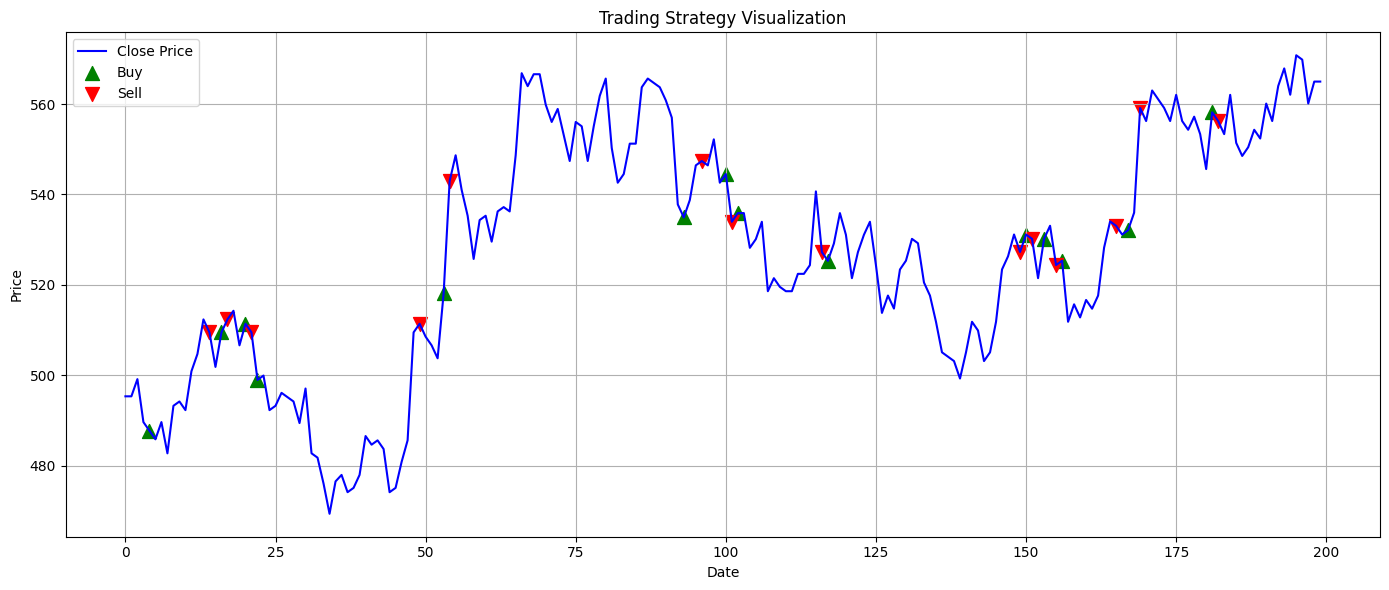

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 487.72806
賣出價格: 548.67554
cash: 1.1249424e+06
額外要扣掉: 4715.456
扣掉後的: 1.1202269e+06
-------------------------------------
買入價格: 534.91876
賣出價格: 564.9819
最終價格: 1.183179e+06


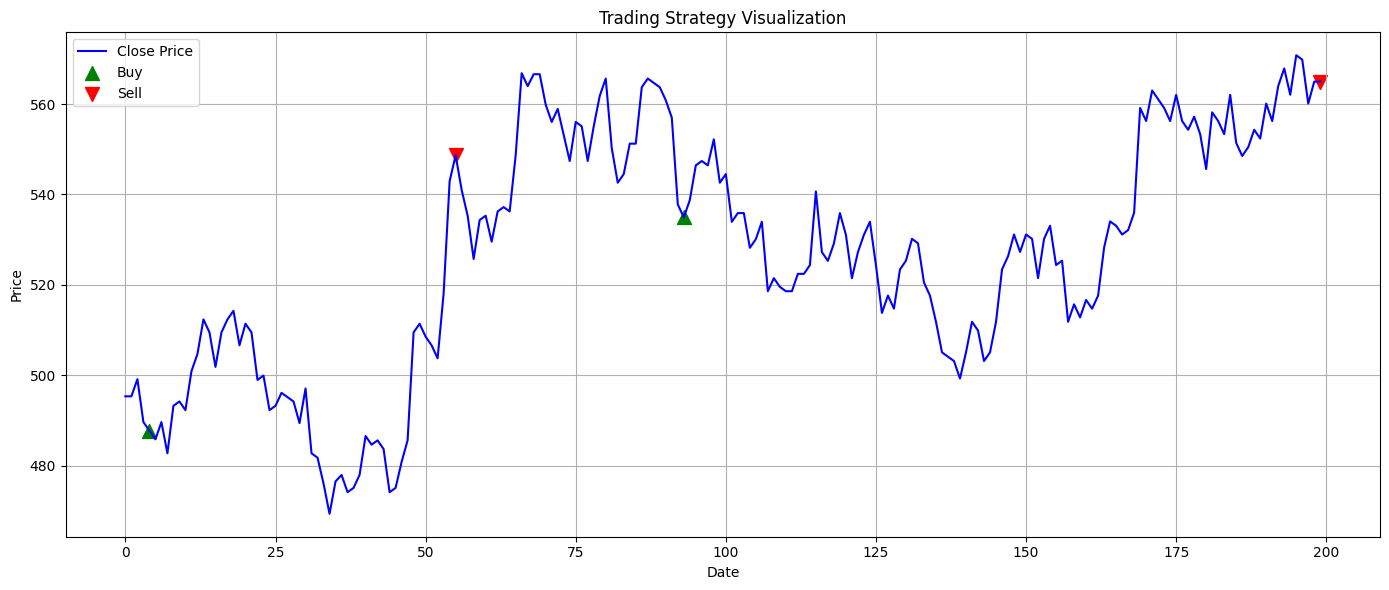

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 75.704 and btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
def preprocess(data_trend, train_ratio, n_past, predict_day):     
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 3])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data2 = df[[c for c in df.columns if c not in ['Date','Adj Close','Volume']]].values
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess(data2, train_ratio, n_past, predict_day)
Y_test.shape

torch.Size([200, 5])

In [17]:
print(Y_test.shape)
pred_arr = []
#len(test_set)
arr = []
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()
    pred = pred.reshape(-1, 1)
    pred = np.repeat(pred, 4, axis=1)
    # print(pred)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[:, 3])
    pred_arr.append(pred_inver[:, 3])
pred_arr = np.array(pred_arr)
pred_arr = torch.tensor(pred_arr)


torch.Size([200, 5])


In [18]:
mae = torch.mean(torch.abs(pred_arr - Y_test))
mape = torch.mean(torch.abs(pred_arr - Y_test)/Y_test)
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(Y_test) - np.array(pred_arr)) ** 2))
# 新增：R²
r2 = r2_score(Y_test, pred_arr)
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

MAE:  10.6433
RMSE: 13.2738
MAPE: 2.0244%
R²:   0.7481


C:\Users\N98141062\AppData\Local\Temp\ipykernel_22904\532043637.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rmse = np.sqrt(np.mean((np.array(Y_test) - np.array(pred_arr)) ** 2))


In [19]:
mae = torch.mean(torch.abs(pred_arr[:,4] - Y_test[:,4]))
mape = torch.mean(torch.abs(pred_arr[:,4] - Y_test[:,4])/Y_test[:,4])
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()}")

mae: 12.846569061279297
mape: 0.02472912333905697


In [20]:
import csv

with open('output/2330tw_output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(pred_arr[:,0])):
    rows[i].append(pred_arr[:,0][i].item())

# 寫回檔案
with open('output/2330tw_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)



In [21]:
import csv

with open('output/2330tw_output5.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(pred_arr[:,4])):
    rows[i].append(pred_arr[:,4][i].item())

# 寫回檔案
with open('output/2330tw_output5.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)
